# 0. Setup Paths

In [5]:
import os

In [6]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [7]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [8]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [9]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [10]:
# https://www.tensorflow.org/install/source_windows

In [18]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [11]:
import object_detection

In [ ]:
!pip list

In [10]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [6]:
labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [14]:
!pip install pytz

  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)


In [10]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

NameError: name 'paths' is not defined

In [11]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

NameError: name 'files' is not defined

In [9]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [10]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

NameError: name 'files' is not defined

In [9]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [14]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [15]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [16]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [20]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [21]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=3000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [22]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet_tuned --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet_tuned\pipeline.config --num_train_steps=3000


In [13]:
!{command}

2021-06-06 16:55:43.166391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-06 16:55:43.167370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-06 16:55:51.072902: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-06-06 16:55:52.049394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-06-06 16:55:52.050321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-06 16:55:52.050782: W tensorflow/stream_executor/platf

W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head._box_encoder_layers
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.0
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.1
W0606 16:56:25.300027  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.2
W0606 16:56:25.300027  9664 util.py:161] Unr

W0606 16:56:25.307990  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.moving_variance
W0606 16:56:25.307990  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.axis
W0606 16:56:25.309018  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.gamma
W0606 16:56:25.309018  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.beta
W0606 16:56:25.309018  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.moving_mean
W0606 16:56:25.309018  9664 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.moving_variance
W0606 16:56:25.309018  9664 util.py:161] Unre

# 7. Evaluate the Model

In [23]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [24]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet_tuned --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet_tuned\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet_tuned


In [25]:
!{command}

^C


# 8. Load Train Model From Checkpoint

In [12]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [14]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [16]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'thumbsdown.d1b10f28-c209-11eb-b5e6-5c879c70213d.jpg')

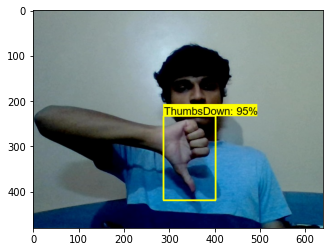

In [17]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [18]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [18]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [19]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [20]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [21]:
!{command}

2021-06-07 17:07:25.530771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:07:25.530802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-07 17:07:28.114171: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-06-07 17:07:29.069501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-06-07 17:07:29.069816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:07:29.070008: W tensorflow/stream_executor/platf

# 11. Conversion to TFJS

In [22]:
!pip install tensorflowjs

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.5.0 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.5.0 requires google-cloud-bigquery>=0.31.0, which is not installed.
tf-models-official 2.5.0 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.5.0 requires oauth2client, which is not installed.
tf-models-official 2.5.0 requires opencv-python-headless, which is not installed.
tf-models-official 2.5.0 requires psutil>=5.4.3, which is not installed.
tf-models-official 2.5.0 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.5.0 requires sacrebleu, which is not installed.
tf-models-official 2.5.0 requires sentencepiece, which is not installed.
tf-models-official 2.5.0 requires seqeval, which is not installed.
tf-models-official 2.5.0 requires tensorflow-datasets, whic

In [23]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [24]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport


In [25]:
!{command}

Writing weight file Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport\model.json...


2021-06-07 17:10:42.293700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:10:42.293731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-07 17:11:00.426778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-06-07 17:11:01.313845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-06-07 17:11:01.314053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:11:01.314204: W tensorflow/stream_executor/platf

In [26]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [27]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [28]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [29]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [30]:
!{command}

2021-06-07 17:13:02.921075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:13:02.921106: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-07 17:13:05.480842: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-06-07 17:13:06.361556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-06-07 17:13:06.361758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:13:06.361903: W tensorflow/stream_executor/platf

In [31]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [32]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [33]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [34]:
!{command}

2021-06-07 17:14:31.914281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:14:31.914316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-07 17:14:40.252014: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-06-07 17:14:41.136630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-06-07 17:14:41.136823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 17:14:41.136970: W tensorflow/stream_executor/platf

# 13. Zip and Export Models 

In [20]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')